In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

def figsize(width=16, height=8):
    pylab.rcParams['figure.figsize'] = (width, height)


In [3]:
import os
os.chdir("../..")

In [5]:
from utils.gamesloader import Top14Loader

games = Top14Loader.get_consolidated_games(compute_glicko=True)
games.head()

season_order            home_team               away_team  home_score  \
185             0        USA Perpignan        Aviron Bayonnais          28   
184             1            Montauban        Stade Toulousain          16   
183             2        RC Toulonnais    Stade Francais Paris          22   
182             3  CS Bourgoin Jallieu                Clermont          28   
181             4             CA Brive  Montpellier Herault RC          30   

     away_score  home_win_main_odd  home_loss_main_odd  draw_main_odd  \
185          20               1.09                6.10          33.50   
184          17               3.24                1.33          22.75   
183          22               1.41                2.86          21.50   
182          37               3.20                1.34          22.75   
181           9               1.21                4.25          24.00   

     n_bookies  season    lnr_id            datetime       home_r     home_rd  \
185          4    2009  361669.0 2009-08-14 13:30:00  1566.274645  343.420676   
184          4    2009  361665.0 2009-08-14 13:30:00  1433.725355  343.420676   
183          4    2009  361673.0 2009-08-14 13:30:00  1500.000000  343.420676   
182          4    2009  361675.0 2009-08-14 13:30:00  1433.725355  343.420676   
181          4    2009  361671.0 2009-08-14 13:30:00  1566.274645  343.420676   

          away_r     away_rd  prev_home_r  prev_away_r  prev_home_rd  \
185  1433.725355  343.420676       1500.0       1500.0         350.0   
184  1566.274645  343.420676       1500.0       1500.0         350.0   
183  1500.000000  343.420676       1500.0       1500.0         350.0   
182  1566.274645  343.420676       1500.0       1500.0         350.0   
181  1433.725355  343.420676       1500.0       1500.0         350.0   

     prev_away_rd  
185         350.0  
184         350.0  
183         350.0  
182         350.0  
181         350.0

In [6]:
games_filtered = games[games["season_order"] >= 36].copy()

In [7]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [12]:
whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

In [18]:
train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]
lr.fit(train_df[["prev_home_r", "prev_away_r"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r", "prev_away_r"]], test_df["home_score"] > test_df["away_score"]))

0.7058823529411765


/home/valentin/anaconda3/envs/main/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


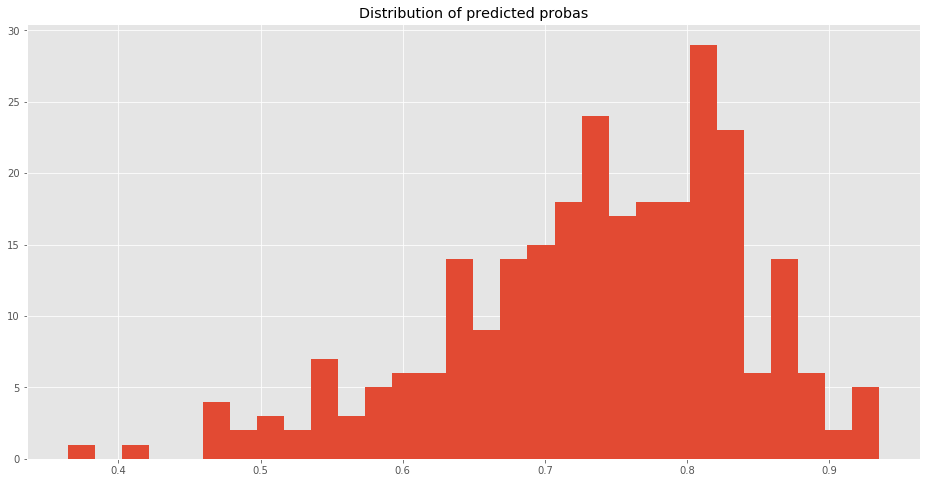

In [64]:
plt.hist(lr.predict_proba(test_df[["prev_home_r", "prev_away_r"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

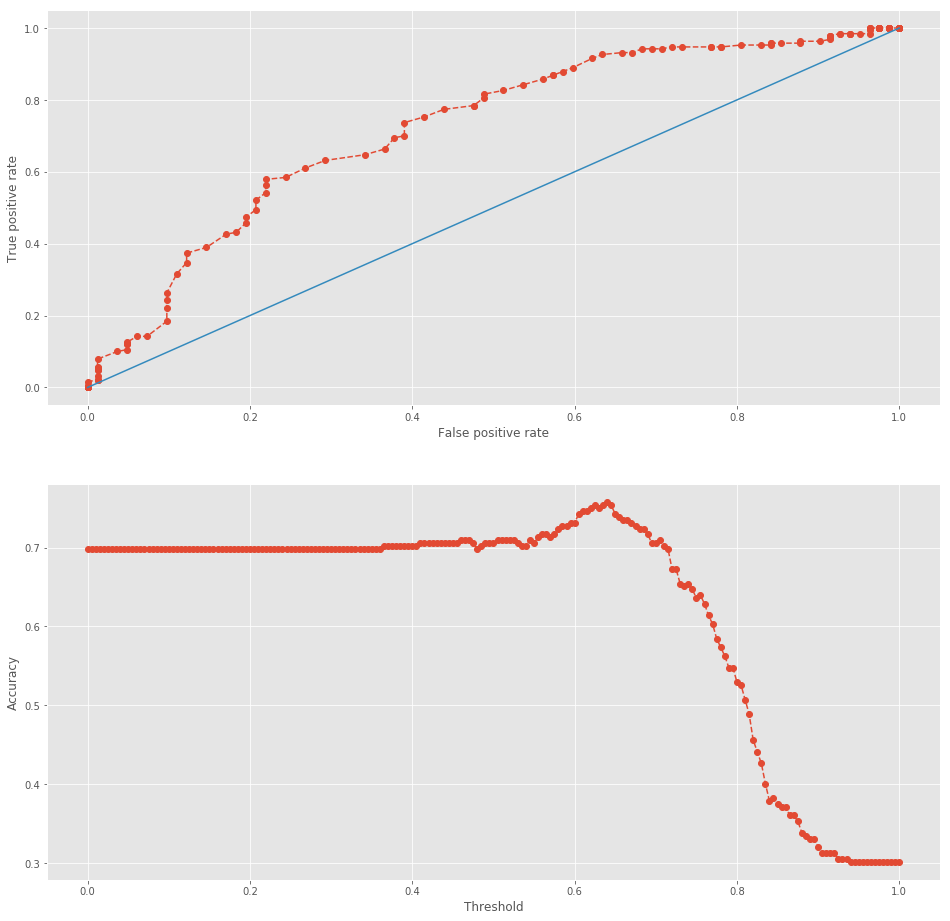

In [61]:
figsize(16, 16)
true_positive_rates = []
false_positive_rates = []
accuracies = []
thresholds = np.linspace(0, 1, 201)
y = test_df["home_score"] > test_df["away_score"]
for threshold in thresholds:
    y_pred = lr.predict_proba(test_df[["prev_home_r", "prev_away_r"]])[:, 1] > threshold
    true_positive_rates.append(np.sum((y_pred == 1) & (y == 1)) / np.sum(y))
    false_positive_rates.append(np.sum((y_pred == 1) & (y == 0)) / np.sum(1 - y))
    accuracies.append(np.sum(y_pred == y) / len(y_pred))
plt.subplot(2, 1, 1)
plt.plot(false_positive_rates, true_positive_rates, "--o")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.subplot(2, 1, 2)
plt.plot(thresholds, accuracies, "--o")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()
figsize()

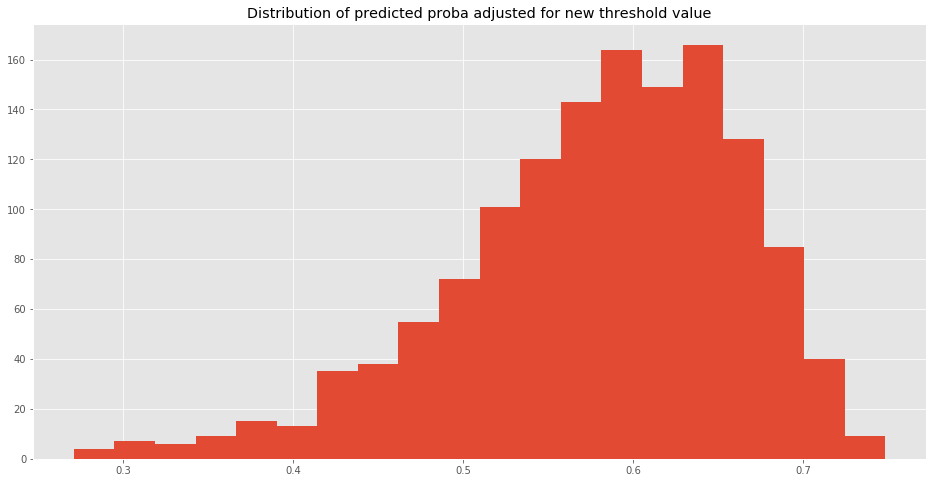

In [63]:
optimal_threshold = thresholds[np.argmax(accuracies)]
plt.hist(lr.predict_proba(games_filtered[["prev_home_r", "prev_away_r"]])[:, 1] / 0.64 / 2, bins=20)
plt.title("Distribution of predicted proba adjusted for new threshold value")
plt.show()

In [69]:
y_pred = lr.predict_proba(test_df[["prev_home_r", "prev_away_r"]])[:, 1] > 0.65
y = test_df["home_score"] > test_df["away_score"]
np.sum(y == y_pred) / len(y)

0.7426470588235294

In [70]:
np.sum(y) / len(y)

0.6985294117647058

# Nested cross validation

We use k-fold cross validation on the training data to chose the best threshold (we select the mean threshold of all the optimal threshold obtained on the k splits). Then, we perform simple cross validation on the remaining test data.

In [130]:
from sklearn.model_selection import KFold

lr = LogisticRegression(solver='lbfgs')

X = np.array(train_df[["prev_home_r", "prev_away_r"]])
y = np.array(train_df["home_score"] > train_df["away_score"])

# Select the best threshold using k-fold cross validation on the training data

kfold = KFold(n_splits=5, shuffle=True)
thresholds_vals = []
accuracies_vals = []

np.random.seed(30)
for k, (sub_train_index, sub_test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X[sub_train_index], X[sub_test_index]
    y_train, y_test = y[sub_train_index], y[sub_test_index]
    
    thresholds = np.linspace(0, 1, 101)
    best_accuracy = -1
    best_threshold = -1
    lr.fit(X_train, y_train)
    for threshold in thresholds:
        y_pred = lr.predict_proba(X_test)[:, 1] > threshold
        accuracy = np.sum(y_pred == y_test) / len(y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    home_wins = np.sum(y_test) / len(y_test)
    y_pred = lr.predict_proba(X_test)[:, 1] > best_threshold
    predicted_wins = np.sum(y_pred) / len(y_pred)
    print(f"Fold {k}, accuracy {best_accuracy:.2%}, threshold {best_threshold:.2%}, home wins {home_wins:.2%}"
          f", predicted wins {predicted_wins:.2%}")
    thresholds_vals.append(best_threshold)
    accuracies_vals.append(best_accuracy)

# Assess the obtained threshold on the test data
    
chosen_threshold = np.mean(thresholds_vals)
lr.fit(X, y)
y_pred = lr.predict_proba(test_df[["prev_home_r", "prev_away_r"]])[:, 1] > chosen_threshold
y = test_df["home_score"] > test_df["away_score"]
accuracy = np.sum(y_pred == y) / len(y)
home_wins = np.sum(y) / len(y)
predicted_wins = np.sum(y_pred) / len(y_pred)
print(f"Global, accuracy {accuracy:.2%}, threshold {chosen_threshold:.2%}, home wins {home_wins:.2%}"
      f", predicted wins {predicted_wins:.2%}")

Fold 0, accuracy 72.94%, threshold 57.00%, home wins 69.72%, predicted wins 91.28%
Fold 1, accuracy 77.06%, threshold 52.00%, home wins 74.31%, predicted wins 96.33%
Fold 2, accuracy 79.26%, threshold 51.00%, home wins 77.88%, predicted wins 97.70%
Fold 3, accuracy 76.04%, threshold 54.00%, home wins 74.19%, predicted wins 92.63%
Fold 4, accuracy 77.42%, threshold 56.00%, home wins 75.58%, predicted wins 96.31%
Global, accuracy 70.22%, threshold 54.00%, home wins 69.85%, predicted wins 94.49%
